In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [2]:
Pkg.update()
Pkg.instantiate()

  ✓ Ipopt_jll


  ✓ Gettext_jll


  ✓ StatsBase


  ✓ Wayland_jll


  ✓ XSLT_jll


  ✓ ArrayInterface


  ✓ SpecialFunctions


  ✓ Xorg_libxcb_jll


  ✓ Glib_jll


  ✓ ArrayInterface → ArrayInterfaceStaticArraysCoreExt


  ✓ DiffRules


  ✓ Xorg_xcb_util_jll


  ✓ Xorg_libX11_jll


  ✓ HTTP


  ✓ Xorg_xcb_util_keysyms_jll
  ✓ Xorg_xcb_util_image_jll


  ✓ ColorVectorSpace


  ✓ StaticArrayInterface


  ✓ Xorg_xcb_util_wm_jll


  ✓ Xorg_libXrender_jll
  ✓ Xorg_xcb_util_renderutil_jll


  ✓ Xorg_libXext_jll


  ✓ Xorg_libXfixes_jll
  ✓ Xorg_libxkbfile_jll


  ✓ Libglvnd_jll


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ Xorg_libXinerama_jll
  ✓ Xorg_libXrandr_jll


  ✓ StaticArrayInterface → StaticArrayInterfaceStaticArraysExt


  ✓ Xorg_libXcursor_jll


  ✓ Colors


  ✓ Xorg_libXi_jll
  ✓ Xorg_xkbcomp_jll
  ✓ EllipsisNotation


  ✓ GLFW_jll


  ✓ Xorg_xkeyboard_config_jll


  ✓ Cairo_jll


  ✓ ForwardDiff


  ✓ xkbcommon_jll


  ✓ HarfBuzz_jll


  ✓ ForwardDiff → ForwardDiffStaticArraysExt


  ✓ Qt6Base_jll


  ✓ libass_jll


  ✓ ColorSchemes


  ✓ FFMPEG_jll


  ✓ FFMPEG


  ✓ GR_jll


  ✓ Parsers


  ✓ JSON


  ✓ Unitful
  ✓ PlotUtils


  ✓ Conda


  ✓ BenchmarkTools


  ✓ UnitfulLatexify


  ✓ IJulia


  ✓ PlotThemes


  ✓ GR


  ✓ RecipesPipeline


  ✓ Plots


  ✓ Plots → IJuliaExt


  ✓ Plots → UnitfulExt


  ✓ MathOptInterface


  ✓ ECOS


  ✓ Gurobi


  ✓ HiGHS


  ✓ Ipopt


  ✓ JuMP


  ✓ ProactiveHRI
  185 dependencies successfully precompiled in 174 seconds. 8 already precompiled.
  1 dependency had warnings during precompilation:
┌ ProactiveHRI [07f2525b-7579-49cc-b9c9-14ef6f703e75]
│  WARNING: Method definition (::Type{ProactiveHRI.PlannerHyperparameters{T}})() where {T} in module ProactiveHRI at /Users/jaspergeldenbott/.julia/packages/Parameters/MK0O4/src/Parameters.jl:491 overwritten on the same line (check for duplicate calls to `include`).
│    ** incremental compilation may be fatally broken for this module **
│  
│  WARNING: Method definition kwcall(Any, Type{ProactiveHRI.PlannerHyperparameters{T}}) where {T} in module ProactiveHRI at /Users/jaspergeldenbott/.julia/packages/Parameters/MK0O4/src/Parameters.jl:491 overwritten on the same line (check for duplicate calls to `include`).
│    ** incremental compilation may be fatally broken for this module **
│  
│  WARNING: Method definition (::Type{ProactiveHRI.PlannerHyperparameters{T}})(Any, Any, Any, Any, A

In [3]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

### Interaction planner

In [4]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [5]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [6]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.330902 seconds (650.50 k allocations: 53.361 MiB, 74.97% compilation time)


  0.098048 seconds (390.63 k allocations: 34.637 MiB, 21.84% gc time)


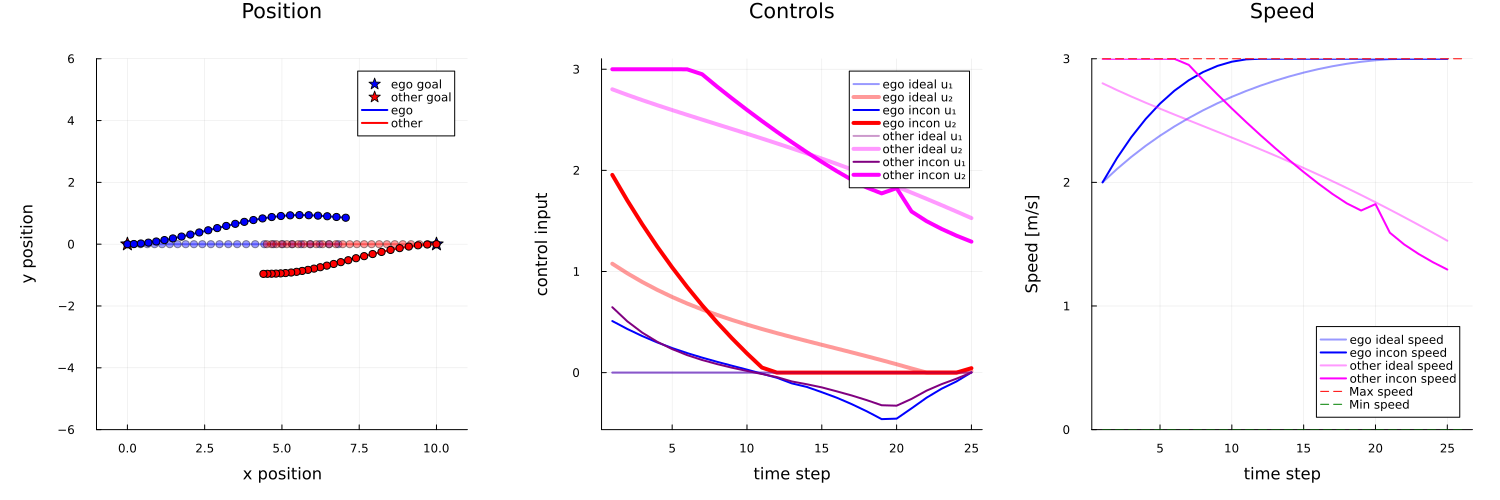

In [7]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [8]:
@time ibr(ip, 3, "ego")

  0.045980 seconds (252.26 k allocations: 21.829 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


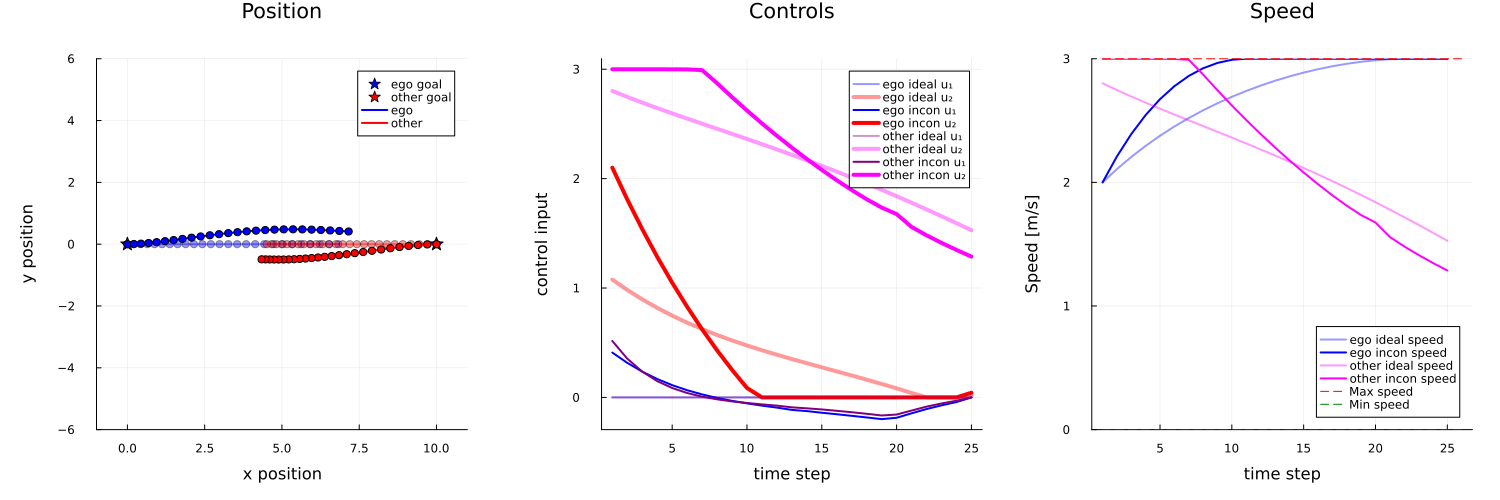

In [9]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_nIlqzuxi70.gif
└ @ Plots /Users/jaspergeldenbott/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_nIlqzuxi70.gif")
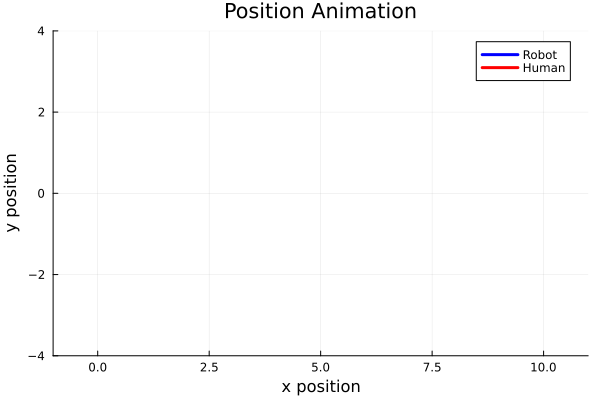

In [10]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

Int64

┌ Info: Saved animation to /var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_vsPWzkxYVI.gif
└ @ Plots /Users/jaspergeldenbott/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_vsPWzkxYVI.gif")
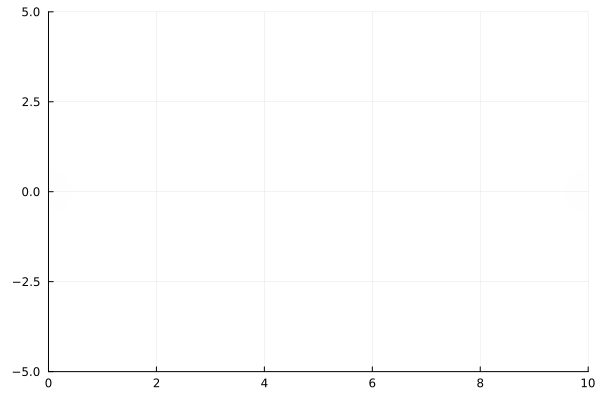

In [11]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [12]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 1 method)

In [41]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 3.0

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([100.; 100.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [42]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [0.; 0.; pi; 2]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [43]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([100.; 100.; 0.; 100.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 100.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [16]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [17]:
robot_path, robot_controls, human_path, human_controls = simulate(robot_ip, human_ip, 50, leader="ego")

([0.0 0.0 0.0 2.0; 0.2149875269742335 0.002017330762525913 0.018339893985219125 2.2999999960945288; … ; 9.197322606421888 0.10059536476291263 -0.12479933722617043 0.5073647974973609; 9.246237113988572 0.09445897567982421 -0.12478012725273087 0.4785934818370619], [0.18339893985219125 2.999999960945289; -0.06180504963080935 2.999999936636659; … ; 0.00021195568523744938 -0.3021337363684572; 0.00019209973439562856 -0.2877131566029894], [10.0 0.0 3.141592653589793 2.0; 9.78500124034821 0.0006306504832437545 3.1358594506454605 2.2999995712876036; … ; 0.45309577755526254 -0.06056681911130722 3.0099922995705164 0.5071406834005462; 0.40470042132615325 -0.05416094998959973 3.0098207835105995 0.46920877529686744], [-0.057332029443324994 2.9999957128760353; 0.9998148684600447 2.999998020529628; … ; -0.001876914427015209 -0.39463667779372824; -0.0017151605991701667 -0.3793190810367875])

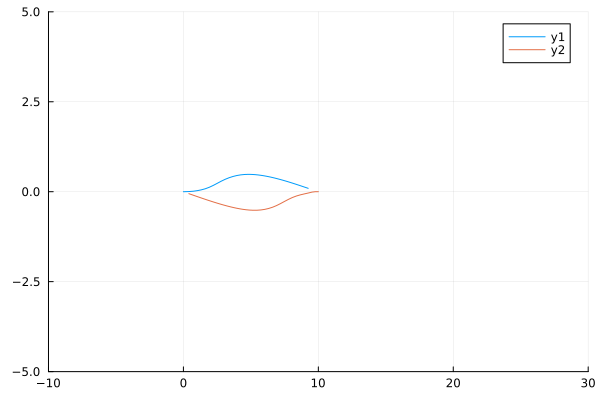

In [18]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-10, 30], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_BKzWZin6xM.gif
└ @ Plots /Users/jaspergeldenbott/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/var/folders/s8/1dzh2b4j4sl22t75kx4fd57m0000gn/T/jl_BKzWZin6xM.gif")
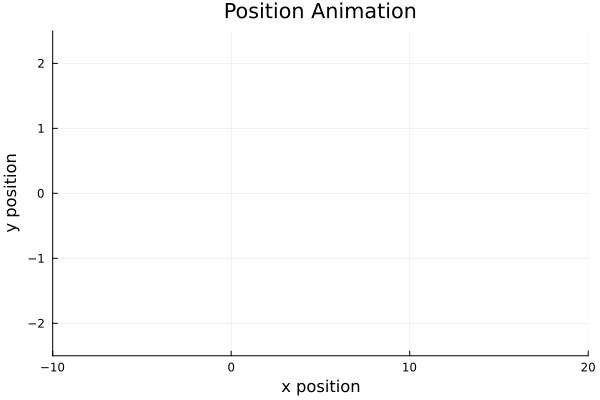

In [19]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [20]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [21]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [22]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.082622 seconds (421.83 k allocations: 37.566 MiB)


  0.096135 seconds (389.82 k allocations: 34.308 MiB, 20.97% gc time)


In [23]:
saved_data_test, _, _, _, _ = ibr_save(ip, 3, "ego")

(SaveData
  previous_ips: Array{InteractionPlanner}((3,))
, [[-5.843688467676274e-10 -6.680462110153698e-10 -3.0032673850454326e-10 1.9999999996061228; 0.2068108187695877 0.004560214939689745 0.04359546938099054 2.1375451273603883; … ; 6.643662212750789 0.6451048935898958 -0.08300116445799478 2.9999980712390864; 6.942880081714721 0.620212170453626 -0.0828460207387593 3.0046213594740654], [1.9307000934386403e-10 -1.6654912124935e-11 -3.240216309378399e-10 2.0000000010885146; 0.20759738527942667 0.004249186680731976 0.04041853575065031 2.153093199259496; … ; 6.719960082240377 0.5082263756944966 -0.06794356915607086 2.999998991435416; 7.019527511799525 0.4878410472766368 -0.06793994297116457 3.0045249427756873], [-8.174255120033533e-10 -6.626269022139546e-10 -3.821541720920577e-10 2.000000000108254; 0.20826500464241138 0.0038736605542955406 0.036691288360956927 2.166244669935594; … ; 6.771282262657991 0.4031318488581169 -0.05491789792722227 2.9999981354602308; 7.071076851551399 0.38665102

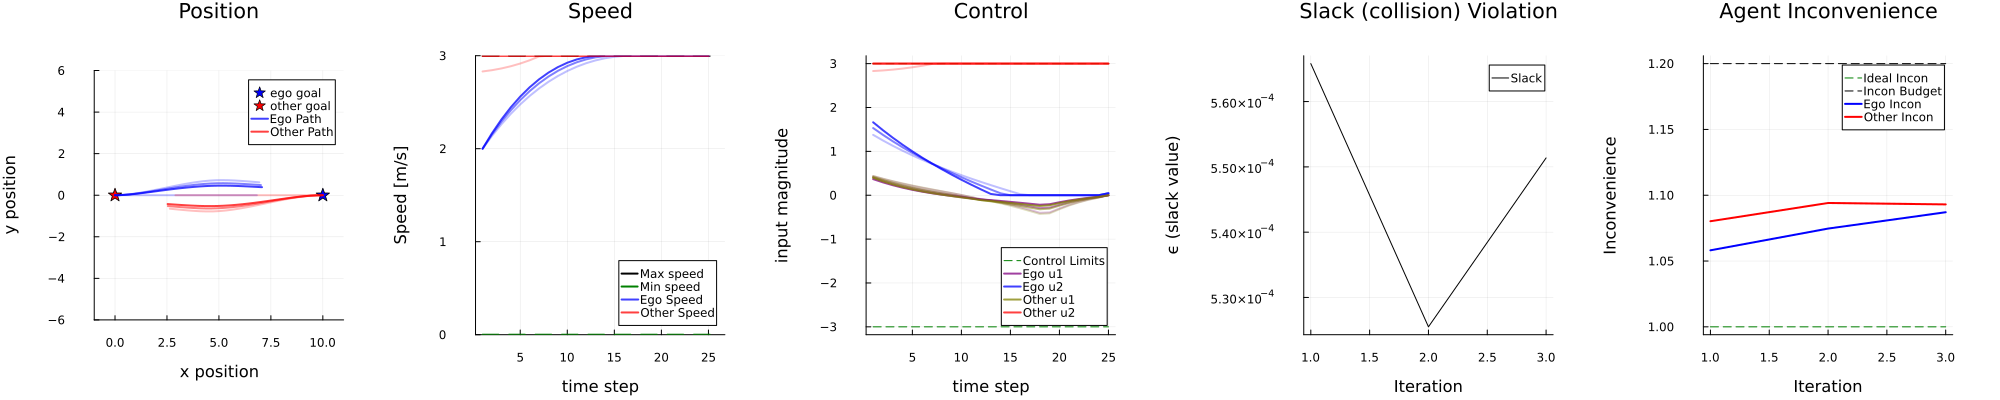

In [24]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

In [25]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b c d e] 
    width=2000
    height=400
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:magenta, linewidth=linewidth, label="", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3])
    plot!(plot_theta, human_xs_mu_09[:,3:3])
    plot!(plot_theta, robot_xs_mu_11[:,3:3])
    plot!(plot_theta, human_xs_mu_11[:,3:3])

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, plot_ctrl, plot_slack_violation, plot_incon, layout=l, size=(width, height))
end


plot_solve_solution (generic function with 5 methods)

# Sim Experimentation Utils

In [26]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)

PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [83.39189843288959, 84.25839871355646, 84.9289578574879, 85.43052359421226, 85.78916122896297, 86.03009826516512, 86.17785688914724, 86.25644088080162, 86.28955203716642, 86.30081836441953  …  86.9388221150547

In [27]:
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-85.39189843102578, -86.33567280055634, -87.22770792011192, -88.07336987433207, -88.87747938375135, -89.64438606891837, -90.3780324796312, -91.0820085805379, -91.75959736609457, -92.41381231686552

In [28]:
sim_data = SimData(sim_params, robot_path, robot_controls, human_path, human_controls)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [100.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-85.39189843102578, -86.33567280055634, -87.22770792011192, -88.07336987433207, -88.87747938375135, -89.64438606891837, -90.3780324796312, -91.0820085805379, -91.75959736609457, -92.413812

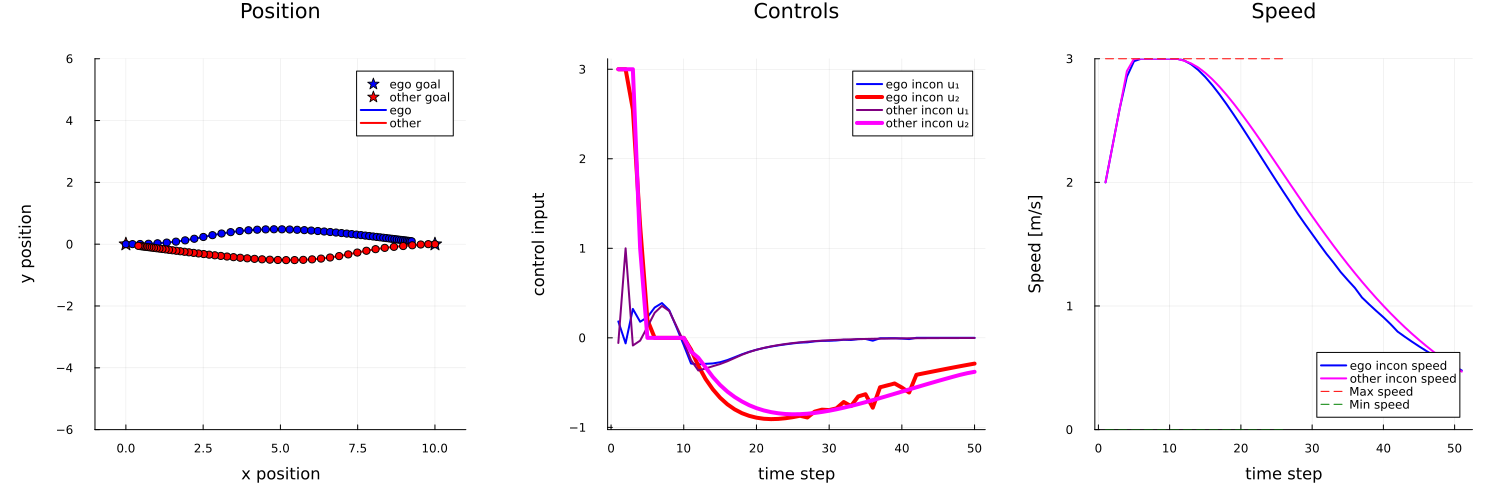

In [29]:
plot_solve_solution(sim_data)

# Experimentation Code

In [30]:
# for experiment in experiments
#     set up problem. Assign hyperparameters. Cycle through hps for each experiment
#     (markup, collision slack, trust region weights, incon weights, collision radius, incon ratio)
#     for opt_param in opt_params
#         assign new opt_params to the problem.
#         (initial states, goal states)
#         register the InteractionPlanner
#         run simulation
#         store data into dictionary w/ with key=run_number
#         (store: hps, opt_params, and paths) -- enough data to recreate the problem and plot Base.load_path_setup_code
#         delete interaction planner before cycling through the loop.
#     end
# end

In [31]:
using ProgressBars

In [32]:
# setting up the problem to be deep copied for experiments
# this is for experimentation where each agent correctly assumes the policy of the oteher agent

# setting up the robot planner
solver = "ECOS"

# defining initial and final states, these are the only things that will be changed in the opt_param sweeps
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2.]
human_goal_state = [0.; 0.; pi; 2.]

# defining the planning horizon and dt
time_horizon = 25
dt = 0.1

# some agent specific parametes
velocity_max_robot = 3.0
velocity_max_human = 3.

human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0

robot = DynamicallyExtendedUnicycle(dt, velocity_max_robot, [1., 3.])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

# defining the robot ip
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
        
# defining the human ip, it will be the exact same as the robot ip, just in a different order

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


### Mohr's Circle-ish Implementation 

In [33]:
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [44]:
test_human = DynamicallyExtendedUnicycle(dt, velocity_max_human, [1., 1.5])

DynamicallyExtendedUnicycle{Float64}
  dt: Float64 0.1
  state_dim: Int64 4
  ctrl_dim: Int64 2
  velocity_min: Float64 0.0
  velocity_max: Float64 3.0
  control_min: Array{Float64}((2,)) [-1.0, -1.5]
  control_max: Array{Float64}((2,)) [1.0, 1.5]


In [45]:
robot_states = mohrs_circle_states(test_human, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [46]:
human_states = [([10., 0., pi, 0.], [0., 0., pi, 0.])]

1-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([10.0, 0.0, 3.141592653589793, 0.0], [0.0, 0.0, 3.141592653589793, 0.0])

### Simulation Code

In [47]:
sim_test = simulation_sweep(robot_ip, human_ip, robot_states, human_states)

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


8.3%┣███▋                                       ┫ 1/12 [00:11<Inf:Inf, InfGs/it]


16.7%┣███████▊                                      ┫ 2/12 [00:22<03:36, 22s/it]


25.0%┣███████████▌                                  ┫ 3/12 [00:32<02:26, 16s/it]


33.3%┣███████████████▍                              ┫ 4/12 [00:43<01:54, 14s/it]


41.7%┣███████████████████▏                          ┫ 5/12 [00:53<01:32, 13s/it]


50.0%┣███████████████████████                       ┫ 6/12 [01:02<01:14, 12s/it]


58.3%┣██████████████████████████▉                   ┫ 7/12 [01:11<00:59, 12s/it]


66.7%┣██████████████████████████████▊               ┫ 8/12 [01:22<00:47, 12s/it]


75.0%┣██████████████████████████████████▌           ┫ 9/12 [01:33<00:35, 12s/it]


83.3%┣█████████████████████████████████████▌       ┫ 10/12 [01:44<00:23, 12s/it]


91.7%┣█████████████████████████████████████████▎   ┫ 11/12 [01:55<00:11, 11s/it]


100.0%┣████████████████████████████████████████████┫ 12/12 [02:05<00:00, 11s/it]
100.0%┣████████████████████████████████████████████┫ 12/12 [02:05<00:00, 11s/it]


Dict{Any, Any} with 12 entries:
  "Run 4"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 10" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 1"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 11" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 6"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 12" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 2"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 9"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 5"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 8"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 7"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 3"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float6

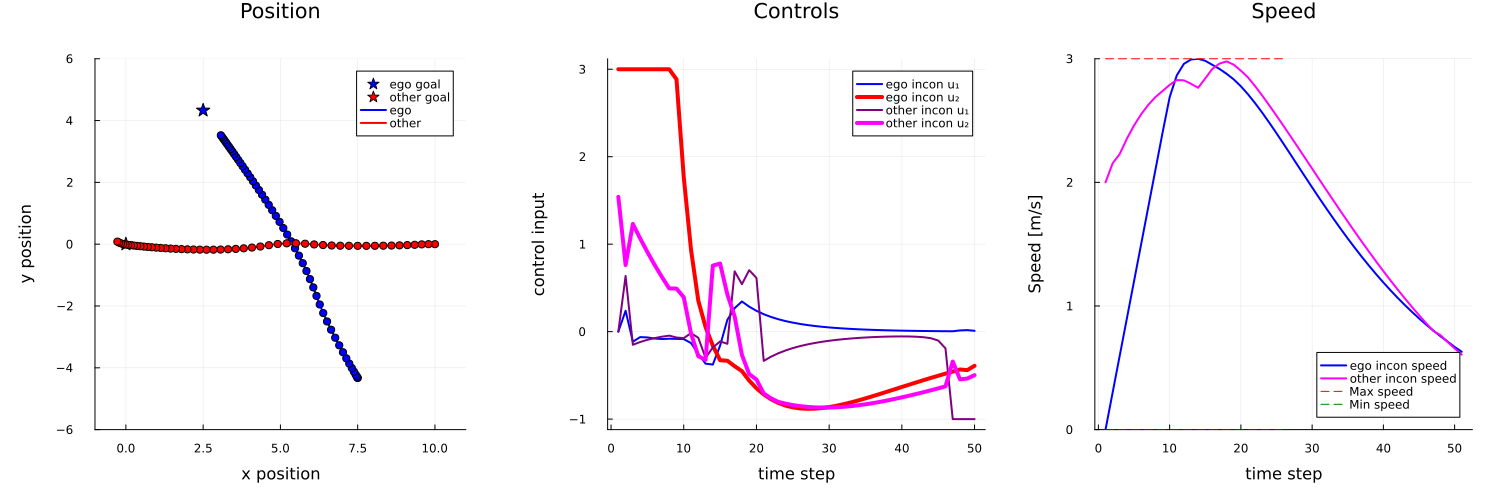

In [52]:
plot_solve_solution(sim_test["Run 5"], pos_xlims=[-1, 11], pos_ylims=[-6, 6])